In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V
from seismicpro.batchflow.models.torch import ResNet18, VGG7
from seismicpro.src import TraceIndex, SeismicDataset, FieldIndex
from seismicpro.src.seismic_batch import (SeismicBatch,
                                            seismic_plot)
from inverse_batch import predict
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from seismicpro.batchflow import action, inbatch_parallel

class InverseBatch(SeismicBatch):
    @action
    @inbatch_parallel(init='_init_component')
    def inv_traces(self, index, src, dst, p=.5):
        pos = self.get_pos(None, src, index)
        trace = getattr(self, src)[pos]
        if np.random.choice([0, 1], p=(1-p, p)):
            getattr(self, dst[0])[pos] = (-1) * trace
            getattr(self, dst[1])[pos] = 1
        else:
            getattr(self, dst[0])[pos] = trace
            getattr(self, dst[1])[pos] = 0

    @action
    def preprocess_component(self, src, dst):
        """Prepeare data for loading into torch models."""
        data = getattr(self, src)
        data_dst = np.stack(data).astype(np.float32)
        setattr(self, dst, data_dst)
        return self
    
    @action
    def preprocess_answers(self, src, dst):
        data = getattr(self, src)
        data_res = data
        setattr(self, dst, data_res.astype(np.int32))
        return self

    @action
    def normalize_traces(self, src, dst, drop_nan=None):
        data = getattr(self, src)
        shape = np.stack(data).shape
        data = np.vstack(data)
        dst_data = (data - np.mean(data, axis=1)[:, np.newaxis]) / \
                   (np.std(data, axis=1)[:, np.newaxis])
        if drop_nan:
            mask = np.argwhere(np.sum(np.isnan(dst_data), axis=1) > 0).flatten()
            for i, m in enumerate(mask):
                new_ix = m - 1 if m + 1 >= len(mask) else m - (-1) ** i
                dst_data[m] = dst_data[new_ix]
        dst_data = dst_data.reshape(shape)
        setattr(self, dst, np.array([i for i in dst_data] + [None])[:-1])
        return self

    @action
    @inbatch_parallel(init='_init_component')
    def crop_trace(self, index, src, dst, size=200):
        pos = self.get_pos(None, src[0], index)
        trace = getattr(self, src[0])[pos]
        picking = getattr(self, src[1])[pos]

        lenght = len(trace.ravel())
        if lenght < picking + int(size/2):
            left = lenght - size
            right = lenght
        elif picking - int(size/2) < 0:
            left = 0
            right = size
        else:
            left = picking - int(size/2)
            right = picking + int(size/2)
        left = np.clip(left, 0, lenght)
        right = np.clip(right, 0, lenght)
        getattr(self, dst)[pos] = np.array(trace[0][left: right].reshape(1, -1))
    
    @action
    def mask_to_pick(self, src, dst, labels=True):
        data = getattr(self, src)

        if not labels:
            data = np.argmax(data, axis=1)

        picking = massive_block(data)
        setattr(self, dst, np.array(picking).ravel())
        return self

In [49]:
a = np.random.choice([-1, 1], size=10)

In [52]:
a[a==-1]=0

In [53]:
a

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [3]:
pal_path = '/data/FB/dataset_1/Pal_Flatiron_1k.sgy'
wz_path = '/data/FB/dataset_2/WZ_Flatiron_1k.sgy'
var_path = '/data/FB/dataset_6/3_FBP_input_ffid_raw-500_off-800.sgy'

pal_index = FieldIndex(name='raw', path=pal_path, extra_headers=['offset'])
pal_index_tr = pal_index.create_subset(pal_index.indices[:50])
pal_index_te = pal_index.create_subset(pal_index.indices[50:100])
pal_data_tr = Dataset(TraceIndex(pal_index_tr), InverseBatch)
pal_data_te = Dataset(TraceIndex(pal_index_te), InverseBatch)

wz_index = FieldIndex(name='raw', path=wz_path, extra_headers=['offset'])
wz_index_tr = wz_index.create_subset(wz_index.indices[:50])
wz_index_te = wz_index.create_subset(wz_index.indices[50:100])
wz_data_tr = Dataset(TraceIndex(wz_index_tr), InverseBatch)
wz_data_te = Dataset(TraceIndex(wz_index_te), InverseBatch)

palwz_index_tr = pal_index_tr.merge(wz_index_tr, how='outer')
palwz_index_te = pal_index_te.merge(wz_index_te, how='outer')
palwz_data_tr = Dataset(TraceIndex(palwz_index_tr), InverseBatch)
palwz_data_te = Dataset(TraceIndex(palwz_index_te), InverseBatch)

# datasets = [pal_data, wz_data, palwz_data]

In [4]:
prep_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .standartize(src='raw', dst='raw')
          .inv_traces(src='raw', dst=['raw', 'labels'])
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
)

In [34]:
SIZE = 751
inputs_config = {
    'raw': {'shape': (1, SIZE)}, 
    'masks': {'shape': (),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

config = {
    'loss': 'ce',
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('SGD', {'lr': 0.005, 'momentum':0.9}),
#     'optimizer': 'Adam',
    'head': dict(num_classes=2),
    'n_iters': 109.5425,
    'decay': dict(name='exp', gamma=0.89),
   'device': 'gpu:0',
}

In [35]:
train_ppl = prep_ppl + (Pipeline()
             .init_model('dynamic', ResNet18, 'model', config)
             .init_variable('loss', init_on_each_run=list)
             .train_model('model', B('raw'), B('labels'),  
                          fetches='loss', save_to=V('loss', mode='a'))
)

In [113]:
def create_test_ppl(train_ppl, data):
    test_ppl = (Pipeline().load(components='raw', fmt='segy')
              .standartize(src='raw', dst='raw')
              .inv_traces(src='raw', dst=['raw', 'labels'], )#p=0.001)
              .import_model('model', train_ppl, 'model')
              .preprocess_component(src='raw', dst='raw')
              .preprocess_answers(src='labels', dst='labels')
              .init_variable('pred', init_on_each_run=list())
              .init_variable('labels', init_on_each_run=list())
              .update_variable('labels', B('labels'), mode='e') 
              .predict_model('model', B('raw'), fetches='predictions',
                             save_to=V('pred', mode='e'))) << data
    return test_ppl

In [74]:
import torch
from sklearn.metrics import f1_score

In [75]:
from IPython.display import clear_output
from tqdm import tqdm

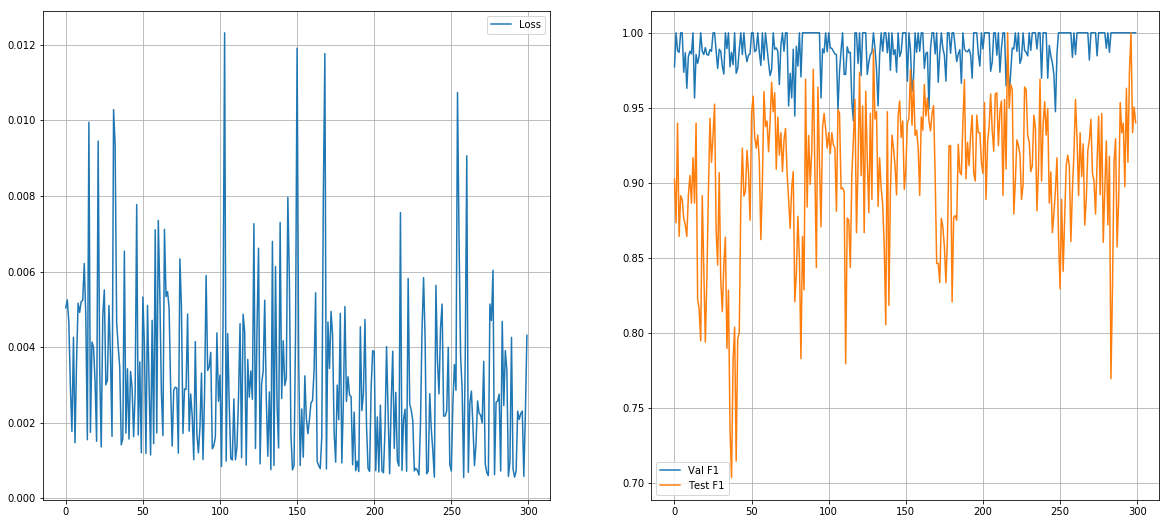



100%|██████████| 520/520 [16:32<00:00,  1.99s/it]

In [39]:
ppl_train = (train_ppl << pal_data_tr)
ppl_val = create_test_ppl(ppl_train, pal_data_te)
ppl_test = create_test_ppl(ppl_train, wz_data_te)
sigm = torch.nn.Sigmoid()
val_score = []
test_score = []
for i in tqdm(range(520)):
    ppl_train.next_batch(400, shuffle=True, drop_last=True)
    ppl_val.next_batch(400, shuffle=True, drop_last=True)
    ppl_test.next_batch(400, shuffle=True, drop_last=True)
    
    val_pred = sigm(torch.Tensor(ppl_val.v('pred')))
    test_pred = sigm(torch.Tensor(ppl_test.v('pred')))
    
    preds_val = np.array(val_pred[:, 1] > .5, dtype=int)
    labels_val = (ppl_val.get_variable('labels'))
    
    preds_test = np.array(test_pred[:, 1] > .5, dtype=int)
    labels_test = (ppl_test.get_variable('labels'))

    val_score.append(f1_score(labels_val, preds_val))
    test_score.append(f1_score(labels_test, preds_test))
    clear_output()
    _, ax = plt.subplots(1, 2, figsize=(20, 9))
    ax[0].plot(ppl_train.v('loss')[-300:], label='Loss')
    ax[1].plot(val_score[-300:], label='Val F1')
    ax[1].plot(test_score[-300:], label='Test F1')
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    plt.show()
    

In [114]:
ppl_val = create_test_ppl(ppl_train, pal_data_te)
ppl_test = create_test_ppl(ppl_train, wz_data_te)

ppl_val.run(400, shuffle=True, drop_last=True, n_epochs=1, bar=True)
ppl_test.run(400, shuffle=True, drop_last=True, n_epochs=1, bar=True)



  0%|          | 0/104 [00:00<?, ?it/s]

  1%|          | 1/104 [00:00<00:40,  2.52it/s]

  2%|▏         | 2/104 [00:00<00:39,  2.61it/s]

  3%|▎         | 3/104 [00:01<00:38,  2.61it/s]

  4%|▍         | 4/104 [00:01<00:38,  2.61it/s]

  5%|▍         | 5/104 [00:02<00:44,  2.23it/s]

  6%|▌         | 6/104 [00:02<00:42,  2.33it/s]

  7%|▋         | 7/104 [00:02<00:39,  2.47it/s]

  8%|▊         | 8/104 [00:03<00:38,  2.52it/s]

  9%|▊         | 9/104 [00:03<00:36,  2.62it/s]

 10%|▉         | 10/104 [00:03<00:35,  2.65it/s]

 11%|█         | 11/104 [00:04<00:34,  2.66it/s]

 12%|█▏        | 12/104 [00:04<00:35,  2.61it/s]

 12%|█▎        | 13/104 [00:05<00:33,  2.71it/s]

 13%|█▎        | 14/104 [00:05<00:32,  2.74it/s]

 14%|█▍        | 15/104 [00:05<00:32,  2.75it/s]

 15%|█▌        | 16/104 [00:06<00:32,  2.74it/s]

 16%|█▋        | 17/104 [00:06<00:37,  2.32it/s]

 17%|█▋        | 18/104 [00:07<00:34,  2.46it/s]

 18%|█▊        | 19/104 [00:07<00:33,  2.57it/s]

 19%|█▉        |

In [115]:
def get_results(ppl):
    pred = sigm(torch.Tensor(ppl.v('pred')))
    preds = np.array(pred[:, 1] > .5, dtype=int)
    labels = np.array(ppl.v('labels'))
    print('Number of inverse traces: {}'.format(sum(labels)))
    print('Number of predicted inverse traces: {}'.format(sum(preds)))
    false_neg = sum(labels[np.where(labels != preds)])
    print('Number of missed inverse traces: {}'.format(false_neg))
    print('F1 : {}'.format(f1_score(labels, preds)))

In [116]:
print('Test traces, same dataset.')
get_results(ppl_val)

print('\n\nTest traces, another dataset.')
get_results(ppl_test)

Test traces, same dataset.
Number of inverse traces: 20815
Number of predicted inverse traces: 20751
Number of missed inverse traces: 64
F1 : 0.9984602800365683


Test traces, another dataset.
Number of inverse traces: 20843
Number of predicted inverse traces: 20711
Number of missed inverse traces: 417
F1 : 0.9831063194878953


In [108]:
print('Test traces, same dataset.')
get_results(ppl_val)

print('\n\nTest traces, another dataset.')
get_results(ppl_test)

Test traces, same dataset.
Number of inverse traces: 45
Number of predicted inverse traces: 47
Number of missed inverse traces: 0
F1 : 0.9782608695652174


Test traces, another dataset.
Number of inverse traces: 32
Number of predicted inverse traces: 546
Number of missed inverse traces: 0
F1 : 0.11072664359861592


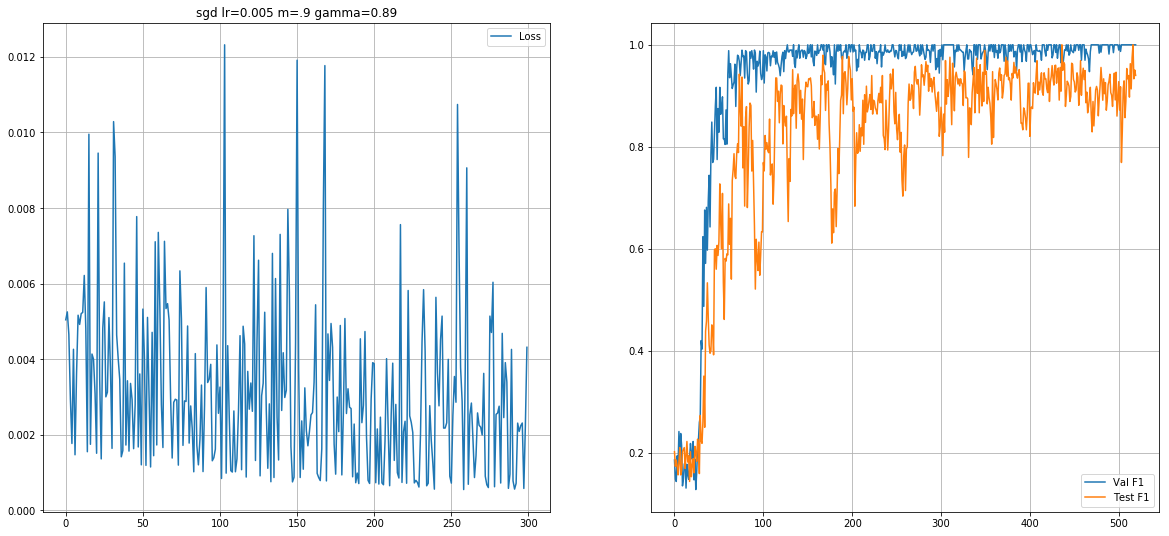

In [40]:
draw_res(ppl_train.v('loss'), val_score, test_score, 'sgd lr=0.005 m=.9 gamma=0.89')

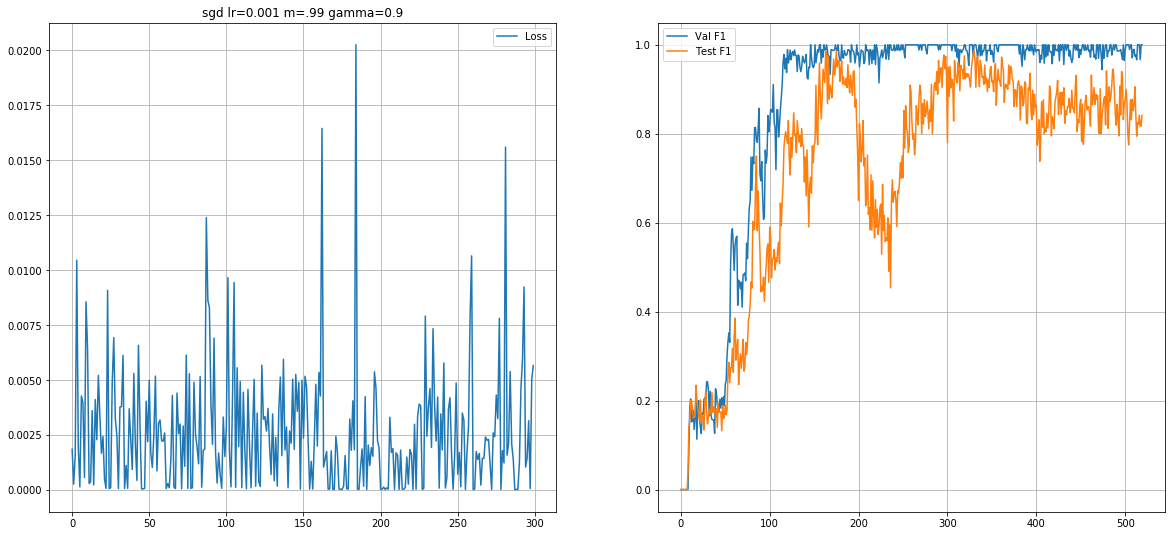

In [33]:
draw_res(ppl_train.v('loss'), val_score, test_score, 'sgd lr=0.001 m=.99 gamma=0.9')

In [29]:
def draw_res(loss, val_score, test_score, title):
    _, ax = plt.subplots(1, 2, figsize=(20, 9))
    ax[0].plot(loss[-300:], label='Loss')
    ax[1].plot(val_score, label='Val F1')
    ax[1].plot(test_score, label='Test F1')
    ax[0].set_title(title)
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    plt.show()

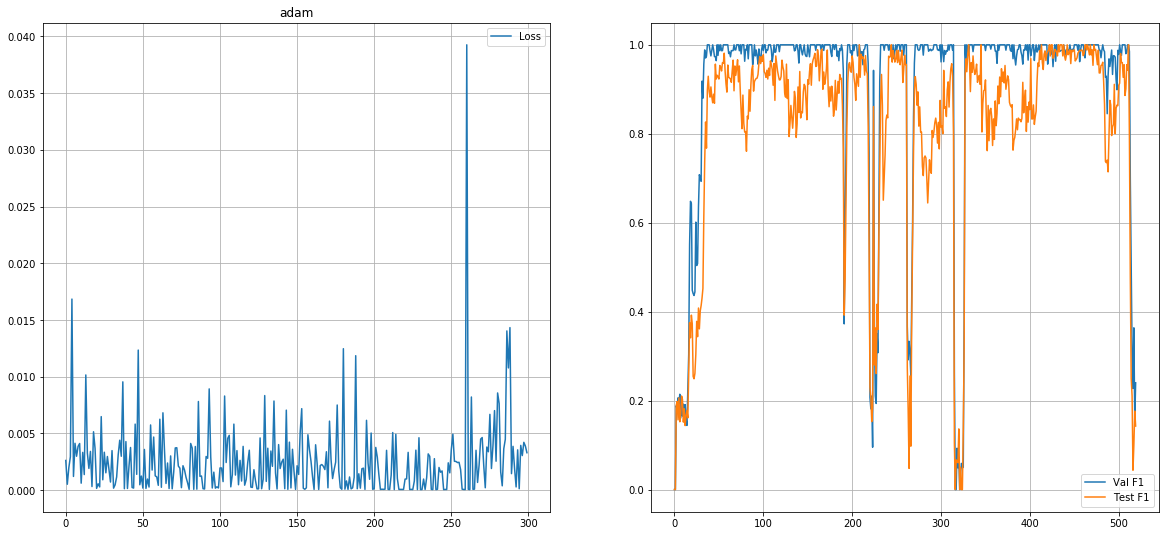

In [22]:
_, ax = plt.subplots(1, 2, figsize=(20, 9))
ax[0].plot(ppl_train.v('loss')[-300:], label='Loss')
ax[1].plot(val_score, label='Val F1')
ax[1].plot(test_score, label='Test F1')
ax[0].set_title('adam')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.show()

In [ ]:
# ppl_val = (test_ppl << pal_data_te)
ppl_val.next_batch(400, shuffle=True, drop_last=True)

In [43]:
print(classification_report(labels_val, preds_val))
print(classification_report(labels_test, preds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       370
           1       1.00      1.00      1.00        30

   micro avg       1.00      1.00      1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       352
           1       0.90      0.98      0.94        48

   micro avg       0.98      0.98      0.98       400
   macro avg       0.95      0.98      0.97       400
weighted avg       0.99      0.98      0.99       400



In [17]:
m = ppl.get_model_by_name('model').model

b = (prep_ppl << train_data).next_batch(400, shuffle=True)

import torch
sigm = torch.nn.Sigmoid()
inp = torch.Tensor(b.raw).to('cuda')
out = sigm(m(inp))

pred = np.array(out.cpu().detach().numpy()[:, 1]>.5, dtype=np.int32)

from sklearn.metrics import classification_report

target = b.labels

print(classification_report(target, pred))

In [14]:
pred_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .standartize(src='raw', dst='raw')
          .inv_traces(src='raw', dst=['raw', 'labels'], p=0.0001)
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
          .init_variable('pred', init_on_each_run=list())
          .init_variable('labels', init_on_each_run=list())
          .update_variable('labels', B('labels'), mode='a') 
          .predict_model('model', B('raw'),
                         fetches='predictions',  save_to=V('pred', mode='a'))
) << pal_data_te

In [15]:
batch = pred_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

100%|██████████| 104/104 [00:37<00:00,  2.87it/s]


In [17]:
preds = np.array(np.concatenate(pred_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
labels = np.concatenate(pred_ppl.get_variable('labels'))

In [18]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41598
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00     41600
   macro avg       1.00      1.00      1.00     41600
weighted avg       1.00      1.00      1.00     41600



In [19]:
print('Accuracy score: {:.3}'.format(accuracy_score(labels, preds)))
print('Number of inverse traces: {}'.format(sum(labels)))
print('Number of predict inverse traces: {}'.format(sum(preds)))
false_neg = sum(labels[np.where(labels != preds)])
print('Number of missed inverse traces: {}'.format(false_neg))

Accuracy score: 1.0
Number of inverse traces: 2
Number of predict inverse traces: 2
Number of missed inverse traces: 0


### Another dataset

In [23]:
!ls /data/FB/dataset_3

3_FBP_1k-ffid_3s.sgy	      3_FBP_1k-ffid_3s_pickingNN.csv
3_FBP_1k-ffid_3s_picking.csv  Vor_Flatiron_1K.sgy


In [24]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
trace_index = TraceIndex(name='raw', path=path_raw, extra_headers=['offset'])

In [25]:
test_index = TraceIndex(trace_index.create_subset(trace_index.indices[10000:40000]))
test_new_data = Dataset(test_index, InverseBatch)

In [26]:
pred_new_ppl = (Pipeline()
          .load(components='raw', fmt='segy')
          .standartize(src='raw', dst='raw')
          .inv_traces(src='raw', dst=['raw', 'labels'], p=0.001)
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw', dst='raw')
          .preprocess_answers(src='labels', dst='labels')
          .init_variable('pred', init_on_each_run=list())
          .init_variable('labels', init_on_each_run=list())
          .update_variable('labels', B('labels'), mode='a') 
          .predict_model('model', B('raw'),
                         fetches='predictions', 
                         save_to=V('pred', mode='a'))
) << test_new_data

In [27]:
pred_new_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

100%|██████████| 75/75 [00:21<00:00,  3.53it/s]


In [28]:
preds = np.array(np.concatenate(pred_new_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
labels = np.concatenate(pred_new_ppl.get_variable('labels'))

In [29]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29975
           1       1.00      1.00      1.00        25

   micro avg       1.00      1.00      1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [30]:
print('Accuracy score: {:.3}'.format(accuracy_score(labels, preds)))
print('Number of inverse traces: {}'.format(sum(labels)))
print('Number of predict inverse traces: {}'.format(sum(preds)))
false_neg = sum(labels[np.where(labels != preds)])
print('Number of missed inverse traces: {}'.format(false_neg))

Accuracy score: 1.0
Number of inverse traces: 25
Number of predict inverse traces: 25
Number of missed inverse traces: 0


обучиться на двух и предсказать на третьем
другой подход? полтора д?
выравнивать трассы?


### Another dataset

In [51]:
path_inv = '/notebooks/egor/inverse_traces/2_prep_input_reverce_tr_check.sgy'
trace_index = TraceIndex(name='raw', path=path_inv, extra_headers=['offset'])

In [70]:
train_subset = np.random.choice(np.arange(trace_index.indices.shape[0]), 700000)
train_index = trace_index.create_subset(trace_index.indices[train_subset])
test_new_data = Dataset(TraceIndex((train_index)), InverseBatch)

In [31]:
pred_new_ppl = (Pipeline()
          .load(components='raw', fmt='segy', tslice=slice(1000))
          .drop_zero_traces(src='raw', num_zero=200)
          .normalize_traces(src='raw', dst='raw')
          .preprocess_component(src='raw', dst='raw')
          .init_model('dynamic', UNet, 'my_model', config=picking_config)
          .add_components('picking')
          .predict_model('my_model', B('raw'), fetches='predictions',  save_to=B('picking', mode='a'))
          .mask_to_pick(src='picking', dst='picking', labels=False)
          .crop_trace(src=['raw', 'picking'], dst='raw_cropped', size=SIZE)
          .normalize_traces(src='raw_cropped', dst='raw_cropped')
          .import_model('model', ppl, 'model')
          .preprocess_component(src='raw_cropped', dst='raw_cropped')
          .init_variable('pred', init_on_each_run=list())
          .predict_model('model', B('raw_cropped'),
                         fetches='predictions',  save_to=V('pred', mode='a'))
) << test_new_data

NameError: name 'UNet' is not defined

In [32]:
batch = pred_new_ppl.run(400, drop_last=True, shuffle=True, bar=True, n_epochs=1)

100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


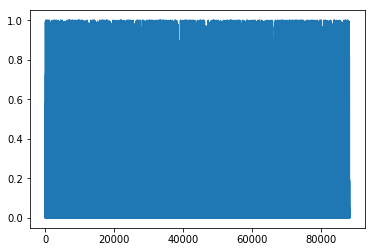

In [55]:
preds = np.array(np.concatenate(pred_new_ppl.get_variable('pred'))[:, 1] > .5, dtype=int)
pred_proba = np.array(np.concatenate(pred_new_ppl.get_variable('pred')))
# labels = np.concatenate(pred_new_ppl.get_variable('labels'))

plt.plot(sigm(torch.Tensor(pred_proba[:, 1])).cpu().detach().numpy())
# plt.ylim(0.3575, 0.362)
# plt.scatter(np.arange(len(labels)), labels)

In [40]:
print(np.sum(preds), len(preds))

2186 88400


(array([86217.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2183.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

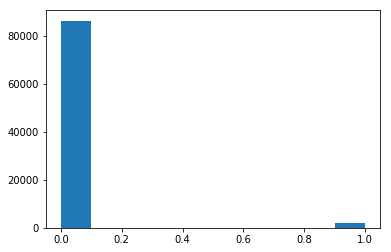

In [56]:
plt.hist(preds)